# MoPy Base Abstractions
The following explains my attempt at creating some basic abstractions for a python package which will calculate seismic source parameters. The abstractions ideally meet a few requirements:

1) They are flexible enough to support a wide range of experimentation in the area of seismic source parameter determination. 

2) They are ergonomic with common operations included as methods. 

3) They integrate fairly well with existing magpy code.

I have not met all these requirements perfectly but it seems to strike a decent balance for a first attempt.

It is important to note that the work presented here only represents an attempt at the package's building blocks; the average user will have a much nicer interface, but these abstractions should make expansion/experimentation possible, and in many cases easy, for super-users.


## Test Data

Before introducing the core abstractions, let's load some nodal data included in the test suite. This is an obfuscated node dataset collected over an active coal mine. 

In [1]:
from pathlib import Path

import obspy
from obsplus.datasets.dataloader import DataSet
from obspy.signal.invsim import corn_freq_2_paz

import mopy


# base path of repo
base = Path().absolute().parent.parent
test_data = base / 'tests' / 'data'


# Create obsplus dataset with node test data, this just allows us to easily pull out obspy data
class CoalNodeDataset(DataSet):
    """ A dataset for the test coal node data. """
    base_path = test_data
    name = "node_dataset"

    def download_stations(self) -> None:
        pass

    
def remove_response(stt) -> obspy.Stream:
    """ Remove response of Fairfied 5 Hz geophone. """
    stt.detrend("linear")
    paz_5hz = corn_freq_2_paz(5.0, damp=0.707)
    paz_5hz["sensitivity"] = 76700
    pre_filt = (0.25, 0.5, 200.0, 250.0)
    stt.simulate(paz_remove=paz_5hz, pre_filt=pre_filt)
    return stt
    

# init the dataset
ds = CoalNodeDataset()
# get a catalog with all the test events
cat = ds.event_client.get_events()
# get an inventory with all the used stations
inv = ds.station_client.get_stations()
# get a dict of {event_id: stream}
fetcher = ds.get_fetcher()
st_dict = dict(fetcher.yield_event_waveforms(time_before=1, time_after=10))
# remove the instrument response (ish) for each stream
for eid, st in st_dict.items():
    st_dict[eid] = remove_response(st)


/home/isti_ew/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/home/isti_ew/anaconda3/lib/python3.7/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


# Quickstart
First, a quick demo, then in-depth discussion. Many of these methods need to be evaluated and better tested, but here is what it looks like now:

In [2]:
# get info on each phase, event, channel, including desired waveform trim times
chif = mopy.ChannelInfo(catalog=cat, inventory=inv, st_dict=st_dict, motion_type='velocity')

In [3]:
# Clip and pre-process time series data
trace_group = mopy.TraceGroup(chif)

In [4]:
# Get spectral data
spec_group = mopy.SpectrumGroup(trace_group)

In [5]:
# get amplitude spectra, apply konno-omachi smoothing, correct attenuation, correct geometric spreading
out = spec_group.abs().ko_smooth().correct_spreading().correct_attenuation().correct_radiation_pattern()

In [6]:
# calculate simple source params. This assumes max vel. is the corner freq.
# then average all displacement freqs left of corner
df = out.calc_simple_source().source_df.dropna()

In [7]:
# now it is just pandas magic to aggregrate them to get estimates for each event
df.groupby('event_id').median()

maxmean             \
                                                  omega0         fc   
event_id                                                              
smi:local/3158881e-3893-4a33-b0e9-2036481e20c3  0.000005  13.333333   
smi:local/60cc4b88-0497-41b4-9744-3884140026af  0.000003  23.333333   
smi:local/a5a139ac-567b-433f-a354-f09209d1584c  0.000002  20.000000   
smi:local/c1e02c51-42f2-4ba7-b10c-b9f86ea4e5aa  0.000023  13.333333   
smi:local/d3b2971e-76ff-4c29-976c-f98975a914c4  0.000002  20.000000   

                                                                          
                                                      moment      energy  
event_id                                                                  
smi:local/3158881e-3893-4a33-b0e9-2036481e20c3  4.646078e+09    1.420557  
smi:local/60cc4b88-0497-41b4-9744-3884140026af  3.270554e+09    3.035179  
smi:local/a5a139ac-567b-433f-a354-f09209d1584c  2.247921e+09    0.508918  
smi:local/c1e02c51-42f2-4ba7-b10c-b9f86ea4e5aa  2.306692e+10  284.198128  
smi:local/d3b2971e-76ff-4c29-976c-f98975a914c4  2.161281e+09    0.895655


# Details

## Dataframes and indices

Each of the classes defined uses a dataframe with a common index scheme. The multi-index contains the following information:
    
    (phase_hint, event_id, seed_id)
   
Using this multi-index means Pandas will take care of all the book-keeping and messy loops can be avoided.

**"Smart data structures and dumb code works a lot better than the other way around"**


## Channel Info
The `ChannelInfo` object does what its name implies; it contains parameters about each channel. Specifically it does the following:

1. calculate all source_receiver distances for each event/station. By default straight ray paths are assumed.

2. determine a suitable waveform window for each row.

3. Determine parameters like geometric spreading coefficients, source seismic velocities, source densities, apparent quality factors etc. 

Nearly all of these can be customized through use of various hooks, sublcassing, or simply by modifying the underlying dataframe. For example, we can easily account for a curved raypath distance, add a distance-dependent quality factor, etc. 


In [8]:
chif = mopy.ChannelInfo(catalog=cat, inventory=inv, st_dict=st_dict, motion_type='velocity')

In [9]:
chif.data

channel  \
phase_hint event_id                                       seed_id              
Noise      smi:local/3158881e-3893-4a33-b0e9-2036481e20c3 1.10.1.DPE     DPE   
                                                          1.10.1.DPN     DPN   
                                                          1.10.1.DPZ     DPZ   
                                                          1.11.1.DPE     DPE   
                                                          1.11.1.DPN     DPN   
                                                          1.11.1.DPZ     DPZ   
                                                          1.12.1.DPE     DPE   
                                                          1.12.1.DPN     DPN   
                                                          1.12.1.DPZ     DPZ   
                                                          1.2.1.DPE      DPE   
                                                          1.2.1.DPN      DPN   
                                                          1.2.1.DPZ      DPZ   
                                                          1.3.1.DPE      DPE   
                                                          1.3.1.DPN      DPN   
                                                          1.3.1.DPZ      DPZ   
                                                          1.4.1.DPE      DPE   
                                                          1.4.1.DPN      DPN   
                                                          1.4.1.DPZ      DPZ   
                                                          1.5.1.DPE      DPE   
                                                          1.5.1.DPN      DPN   
                                                          1.5.1.DPZ      DPZ   
                                                          1.6.1.DPE      DPE   
                                                          1.6.1.DPN      DPN   
                                                          1.6.1.DPZ      DPZ   
                                                          1.7.1.DPE      DPE   
                                                          1.7.1.DPN      DPN   
                                                          1.7.1.DPZ      DPZ   
                                                          1.8.1.DPE      DPE   
                                                          1.8.1.DPN      DPN   
                                                          1.8.1.DPZ      DPZ   
...                                                                      ...   
P          smi:local/d3b2971e-76ff-4c29-976c-f98975a914c4 1.11.1.DPE     DPE   
                                                          1.11.1.DPN     DPN   
                                                          1.11.1.DPZ     DPZ   
                                                          1.12.1.DPE     DPE   
                                                          1.12.1.DPN     DPN   
                                                          1.12.1.DPZ     DPZ   
                                                          1.2.1.DPE      DPE   
                                                          1.2.1.DPN      DPN   
                                                          1.2.1.DPZ      DPZ   
                                                          1.3.1.DPE      DPE   
                                                          1.3.1.DPN      DPN   
                                                          1.3.1.DPZ      DPZ   
                                                          1.4.1.DPE      DPE   
                                                          1.4.1.DPN      DPN   
                                                          1.4.1.DPZ      DPZ   
                                                          1.5.1.DPE      DPE   
                                                          1.5.1.DPN      DPN   
                                                          1.5.1.DPZ  

In [10]:
print(chif.data.columns)

Index(['channel', 'location', 'network', 'sampling_rate', 'station', 'time',
       'trace', 'tw_end', 'tw_start', 'station_depth', 'station_azimuth',
       'station_dip', 'distance', 'horizontal_distance', 'depth_distance',
       'azimuth', 'ray_path_length', 'velocity', 'radiation_coefficient',
       'quality_factor', 'spreading_coefficient', 'density', 'shear_modulus',
       'free_surface_coefficient'],
      dtype='object')


## TraceGroup
The `TraceGroup` contains the channel info, but goes a step further to extract time series data and, by default, prepare it for fft.

In this stage the data are detrended, zero-padded, and tapered. Again, all of this can be customized. 

In [11]:
trace_group = mopy.TraceGroup(chif)

## SpectrumGroup
Next, the data are transformed to the frequency domain when a `SpectrumGroup` is instantiated. `SpectrumGroup` has  methods for common corrections, as seen in the quickstart, and some basic visualization. Again, there are a number of overwrite-able hooks to allow customizations, or they can be applied simply using the appropriate method calls.

In [12]:
spec_group = mopy.SpectrumGroup(trace_group)

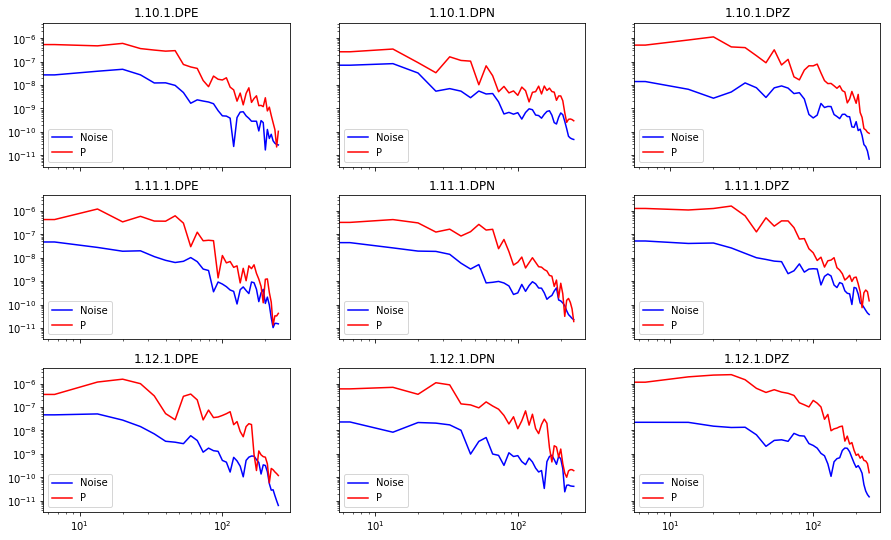

In [13]:
# plot first 4 traces of 3rd event
spec_group.plot(event_id=2, limit=3)